## Project Overview

This project investigates the effectiveness of Malaysia’s COVID-19 containment strategy, with a focus on Movement Control Orders (MCOs). These policies aimed to reduce virus transmission by limiting population mobility. 

Using daily active case counts and KTMB ridership data as a proxy for public movement, the analysis explores whether reduced mobility during MCO phases corresponded with declines in COVID-19 cases. The goal is to assess if MCO-driven mobility restrictions had a measurable impact on controlling outbreaks.


# 📦 Import Necessary Libraries

We begin by importing essential Python libraries for data handling and visualisation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

# 📂 Load Data
Load in all four datasets: KTMB ridership, MCO timelines, and COVID Cases.

In [2]:
ridership_df = pd.read_csv('data/ktmb_ridership.csv')
mco_df = pd.read_csv('data/mco_timeline.csv')
covid_df = pd.read_csv('data/covid_cases.csv')

In [3]:
display(ridership_df.head())
display(mco_df.head())
display(covid_df.head())

,date,service,ridership
0,2020-11-01,ets,35212
1,2020-12-01,ets,109849
2,2021-01-01,ets,68828
3,2021-02-01,ets,28999
4,2021-03-01,ets,56682


,phase,start_date,end_date
0,MCO,2020-03-18,2020-05-03
1,CMCO,2020-05-04,2020-06-09
2,RMCO,2020-06-10,2021-05-31
3,FMCO,2021-06-01,2021-07-04
4,NRP,2021-07-05,2021-12-31


,date,state,cases_new,cases_import,cases_recovered,cases_active,cases_cluster
0,2020-01-25,Malaysia,4,4,0,4,0
1,2020-01-26,Malaysia,0,0,0,4,0
2,2020-01-27,Malaysia,0,0,0,4,0
3,2020-01-28,Malaysia,0,0,0,4,0
4,2020-01-29,Malaysia,3,3,0,7,0


# 🧹 Data Cleaning

In [4]:
# Group all datasets into a dictionary for easier iteration
dfs = {
    'Ridership Data': ridership_df,
    'MCO Timeline Data': mco_df,
    'COVID Cases Data': covid_df
}

for name, df in dfs.items():
    print(f"\n \033[1m{name}\033[0m") # Bold for better readability
    display(df.info())


 Ridership Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       225 non-null    object
 1   service    225 non-null    object
 2   ridership  225 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 5.4+ KB


None


 MCO Timeline Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   phase       5 non-null      object
 1   start_date  5 non-null      object
 2   end_date    5 non-null      object
dtypes: object(3)
memory usage: 252.0+ bytes


None


 COVID Cases Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33218 entries, 0 to 33217
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             33218 non-null  object
 1   state            33218 non-null  object
 2   cases_new        33218 non-null  int64 
 3   cases_import     33218 non-null  int64 
 4   cases_recovered  33218 non-null  int64 
 5   cases_active     33218 non-null  int64 
 6   cases_cluster    33218 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.8+ MB


None

In [5]:
# Double check for nulls
for name, df in dfs.items():
    print(f"\n{name} - Missing Values:\n{df.isnull().sum()}")

# Check for duplicates
for name, df in dfs.items():
    print(f"\n{name} - Duplicates: {df.duplicated().sum()}")


Ridership Data - Missing Values:
date         0
service      0
ridership    0
dtype: int64

MCO Timeline Data - Missing Values:
phase         0
start_date    0
end_date      0
dtype: int64

COVID Cases Data - Missing Values:
date               0
state              0
cases_new          0
cases_import       0
cases_recovered    0
cases_active       0
cases_cluster      0
dtype: int64

Ridership Data - Duplicates: 0

MCO Timeline Data - Duplicates: 0

COVID Cases Data - Duplicates: 0


In [6]:
# Convert date columns in all datasets to datetime format
ridership_df['date'] = pd.to_datetime(ridership_df['date'])
mco_df['start_date'] = pd.to_datetime(mco_df['start_date'])
mco_df['end_date'] = pd.to_datetime(mco_df['end_date'])
covid_df['date'] = pd.to_datetime(covid_df['date'])

# Sort by date for easier time series analysis
ridership_df.sort_values('date', inplace=True)
mco_df.sort_values('start_date', inplace=True)
covid_df.sort_values('date', inplace=True)

We convert relevant columns to datetime format to enable proper time-based filtering and plotting.

In [7]:
# Summarise each dataset for easier interpretation to see if we can find anything unusual
print("\033[1m==Ridership Data==\033[0m")
display(ridership_df.describe(include='all').transpose())

print("\n\033[1m==COVID Case Data==\033[0m")
display(covid_df.describe(include='all').transpose())

==Ridership Data==


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
date,225,NaN,NaN,NaN,2023-05-24 13:00:48,2020-11-01 00:00:00,2022-05-01 00:00:00,2023-08-01 00:00:00,2024-07-01 00:00:00,2025-06-01 00:00:00,NaN
service,225,5,ets,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ridership,225.0,NaN,NaN,NaN,294820.293333,2128.0,119388.0,259504.0,348738.0,1124984.0,255063.412563



==COVID Case Data==


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
date,33218,NaN,NaN,NaN,2022-09-27 12:00:00,2020-01-25 00:00:00,2021-05-27 00:00:00,2022-09-27 12:00:00,2024-01-29 00:00:00,2025-05-31 00:00:00,NaN
state,33218,17,Malaysia,1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cases_new,33218.0,NaN,NaN,NaN,321.912999,0.0,2.0,16.0,124.0,33406.0,1533.3418
cases_import,33218.0,NaN,NaN,NaN,2.367512,0.0,0.0,0.0,0.0,719.0,19.908229
cases_recovered,33218.0,NaN,NaN,NaN,318.773496,0.0,2.0,14.0,117.0,33872.0,1523.745757
cases_active,33218.0,NaN,NaN,NaN,4078.575351,-630.0,54.0,442.0,2143.0,323791.0,17423.261007
cases_cluster,33218.0,NaN,NaN,NaN,32.18496,0.0,0.0,0.0,2.0,3394.0,166.959402


### Summary Interpretation

**Ridership Data:**
- Large gap between 75% percentile and max value in ridership.
- This spike is due to the introduction of Komuter data being added.

**COVID Case Data:**
- cases_active has a minimum of -630, which is not valid. We will explore ways to deal with this within this section.
- Interquartile range shows heavy skewness, especially in active cases and new cases.
- We'll investigate this further with added context.

#### COVID Cases Data Cleaning

The COVID dataset contains several entries where the number of active cases is negative, which is logically impossible - active cases should never fall below zero. The theoretical minimum is 0 active cases.

In [8]:
# Filter rows with negative active cases
negative_active = covid_df[covid_df['cases_active'] < 0]

# Display the top 10 rows with the most negative values
display(negative_active.sort_values('cases_active').head(10))

# Show affected states
print("States with negative active cases:")
print(negative_active['state'].unique())

,date,state,cases_new,cases_import,cases_recovered,cases_active,cases_cluster
5061,2023-03-23,Kedah,8,0,14,-630,0
5062,2023-03-24,Kedah,6,0,4,-628,0
5058,2023-03-20,Kedah,1,0,5,-627,0
5059,2023-03-21,Kedah,9,0,8,-626,0
5043,2023-03-05,Kedah,7,1,61,-625,0
5060,2023-03-22,Kedah,8,0,6,-624,0
5057,2023-03-19,Kedah,4,0,7,-623,0
5063,2023-03-25,Kedah,9,0,4,-623,0
5045,2023-03-07,Kedah,6,0,6,-620,0
5056,2023-03-18,Kedah,5,1,10,-620,0


States with negative active cases:
['Kedah' 'Pulau Pinang' 'Kelantan' 'Selangor' 'Sarawak' 'Negeri Sembilan']


Several states show negative `cases_active` values, which are not feasible. We calculate active cases manually (new - recovered) to validate and explore these anomalies.

In [9]:
# Sort data by state and date
covid_df = covid_df.sort_values(['state', 'date'])

# Calculate cumulative active cases manually per state
covid_df['calculated_active'] = (
    covid_df.groupby('state')
    .apply(lambda group: (group['cases_new'] - group['cases_recovered']).cumsum())
    .reset_index(level=0, drop=True)
)

display(covid_df.sort_values('cases_active').head(10))

,date,state,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,calculated_active
5061,2023-03-23,Kedah,8,0,14,-630,0,2108
5062,2023-03-24,Kedah,6,0,4,-628,0,2110
5058,2023-03-20,Kedah,1,0,5,-627,0,2111
5059,2023-03-21,Kedah,9,0,8,-626,0,2112
5043,2023-03-05,Kedah,7,1,61,-625,0,2112
5060,2023-03-22,Kedah,8,0,6,-624,0,2114
5057,2023-03-19,Kedah,4,0,7,-623,0,2115
5063,2023-03-25,Kedah,9,0,4,-623,0,2115
5044,2023-03-06,Kedah,11,2,6,-620,0,2117
5045,2023-03-07,Kedah,6,0,6,-620,0,2117


From the sample above, we observed multiple instances where `cases_active` values were negative, which is not logically valid. These anomalies are likely due to reporting corrections, recovery data lags, or data entry issues.

To verify this, we generated a new `calculated_active` column using the formula:
`cases_new + cases_import - cases_recovered`.

While this offered some consistency, we ultimately retained the original `cases_active` column after setting any negative values to zero. This approach ensured data integrity without overcomplicating the aggregation process.


### Aggregating COVID-19 Cases for West Malaysia

For this analysis, we focus exclusively on West Malaysia, as KTMB railway services operate only within this region. Including East Malaysian states (Sabah, Sarawak, Labuan) would introduce unnecessary noise and misalignment with the mobility data.

After cleaning, we aggregate the daily COVID-19 data by summing the case counts across all West Malaysian states. This produces a regional-level time series that aligns with the scale of KTMB operations and supports meaningful trend comparisons with ridership data.


In [10]:
# List of West Malaysia states based on screenshots
west_malaysia_states = [
    'Johor', 'Kedah', 'Kelantan', 'Melaka', 'Negeri Sembilan', 'Pahang',
    'Perak', 'Perlis', 'Pulau Pinang', 'Selangor', 'Terengganu',
    'W.P. Kuala Lumpur', 'W.P. Putrajaya'
]

# Step 1: Set negative active cases to 0
covid_df['cases_active'] = covid_df['cases_active'].clip(lower=0)

# Step 2: Filter to only West Malaysia states
west_covid = covid_df[covid_df['state'].isin(west_malaysia_states)].copy()

# Step 3: Group by date and sum case metrics
west_covid_df = (
    west_covid
    .groupby('date')[['cases_new', 'cases_import', 'cases_recovered', 'cases_active', 'cases_cluster']]
    .sum()
    .reset_index()
)

# Display preview
west_covid_df.head()

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster
0,2020-01-25,4,4,0,4,0
1,2020-01-26,0,0,0,4,0
2,2020-01-27,0,0,0,4,0
3,2020-01-28,0,0,0,4,0
4,2020-01-29,3,3,0,7,0


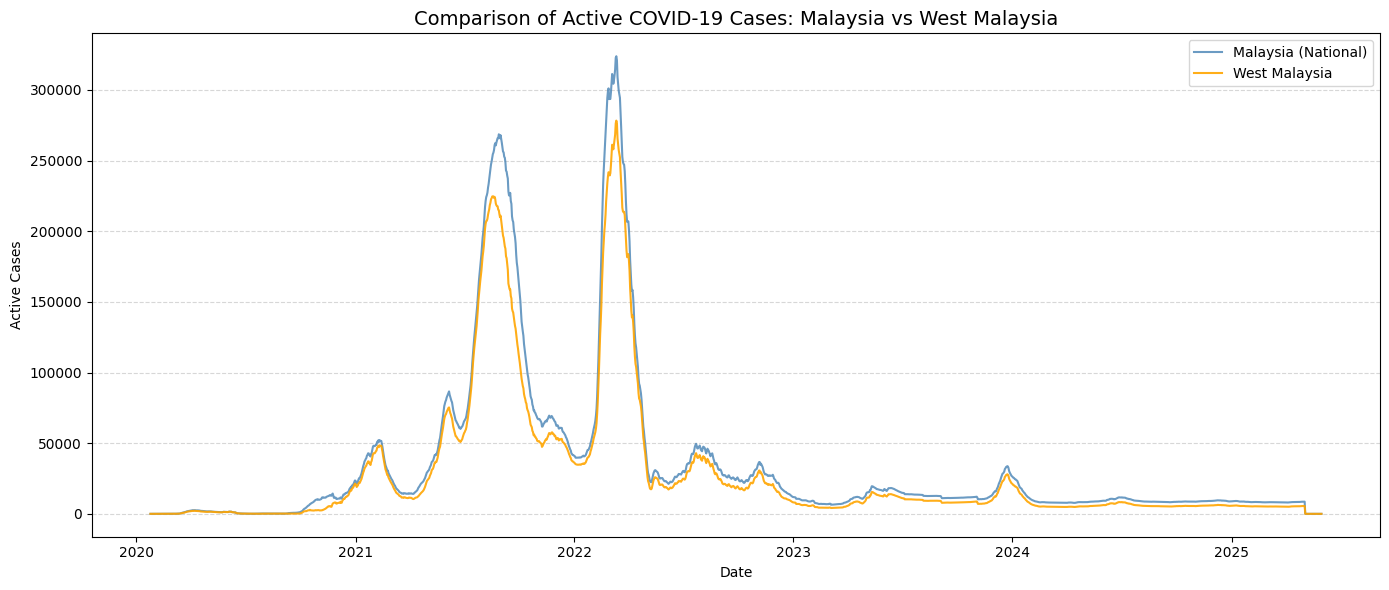

In [11]:
national_df = covid_df[covid_df['state'] == 'Malaysia'].copy()

# Ensure 'date' columns are in datetime format
national_df['date'] = pd.to_datetime(national_df['date'])
west_covid_df['date'] = pd.to_datetime(west_covid_df['date'])

# Create the plot
plt.figure(figsize=(14, 6))

# Plot national data
plt.plot(national_df['date'], national_df['cases_active'], label='Malaysia (National)', color='steelblue', alpha=0.8)

# Plot West Malaysia data
plt.plot(west_covid_df['date'], west_covid_df['cases_active'], label='West Malaysia', color='orange', alpha=0.9)

# Styling
plt.title('Comparison of Active COVID-19 Cases: Malaysia vs West Malaysia', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Active Cases')

# Add horizontal gridlines only
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Format x-axis: show one tick per year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# Final check: ensure no negative active cases remain in the West Malaysia data
negatives_remaining = west_covid_df[west_covid_df['cases_active'] < 0]

if negatives_remaining.empty:
    print("No negative active cases remain in West Malaysia data.")
else:
    print("Negative active cases still present in West Malaysia data.")

No negative active cases remain in West Malaysia data.


In [13]:
# Confirm no missing values in any dataset

print("\n\033[1mRidership Data\033[0m")
print(ridership_df.isnull().sum())

print("\n\033[1mMCO Phases Data\033[0m")
print(mco_df.isnull().sum())

print("\n\033[1mCOVID Case Data (West Malaysia)\033[0m")
print(west_covid_df.isnull().sum())


Ridership Data
date         0
service      0
ridership    0
dtype: int64

MCO Phases Data
phase         0
start_date    0
end_date      0
dtype: int64

COVID Case Data (West Malaysia)
date               0
cases_new          0
cases_import       0
cases_recovered    0
cases_active       0
cases_cluster      0
dtype: int64


### ✅ Final Data Quality Check

All datasets have been verified to contain no missing values. This ensures reliability in our subsequent analysis and visualisations.

**Note:** Going forward, all references to COVID-19 case data will specifically refer to West Malaysia only. This is because the scope of this project focuses on regions served by KTMB, which operates exclusively in Peninsular (West) Malaysia.


# 📈 Data Visualisation

#### ⚠️ Notes on Ridership Data

The starting dates for each KTMB service differ due to a phased rollout of the KITS system. This may result in unequal time coverage when comparing services.


## Plot 1: Monthly Total KTMB Ridership Over Time

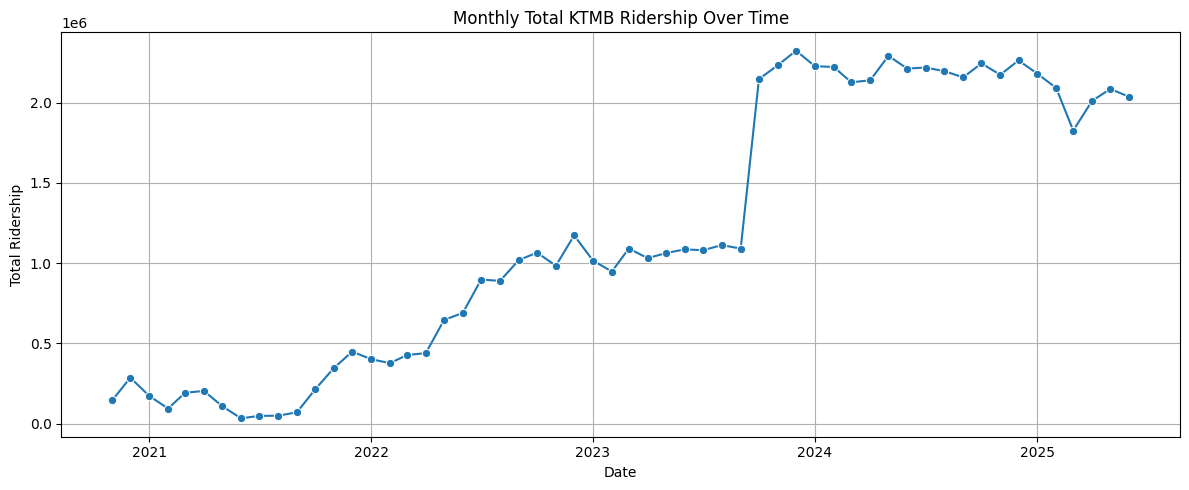

In [14]:
# Group total ridership per month
monthly_ridership = ridership_df.groupby('date')['ridership'].sum().reset_index()

# Plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_ridership, x='date', y='ridership', marker='o')
plt.title('Monthly Total KTMB Ridership Over Time')
plt.xlabel('Date')
plt.ylabel('Total Ridership')
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation of the Chart: Monthly Total KTMB Ridership Over Time

**Observations:**
- A clear recovery trend starting in late 2021.
- A sudden and sharp increase in ridership around mid-2023. This is due to the phased out rollout of KITS, with the `Komuter` data being added in late 2023.

---

## Plot 2: KTMB Ridership by Service Over Time

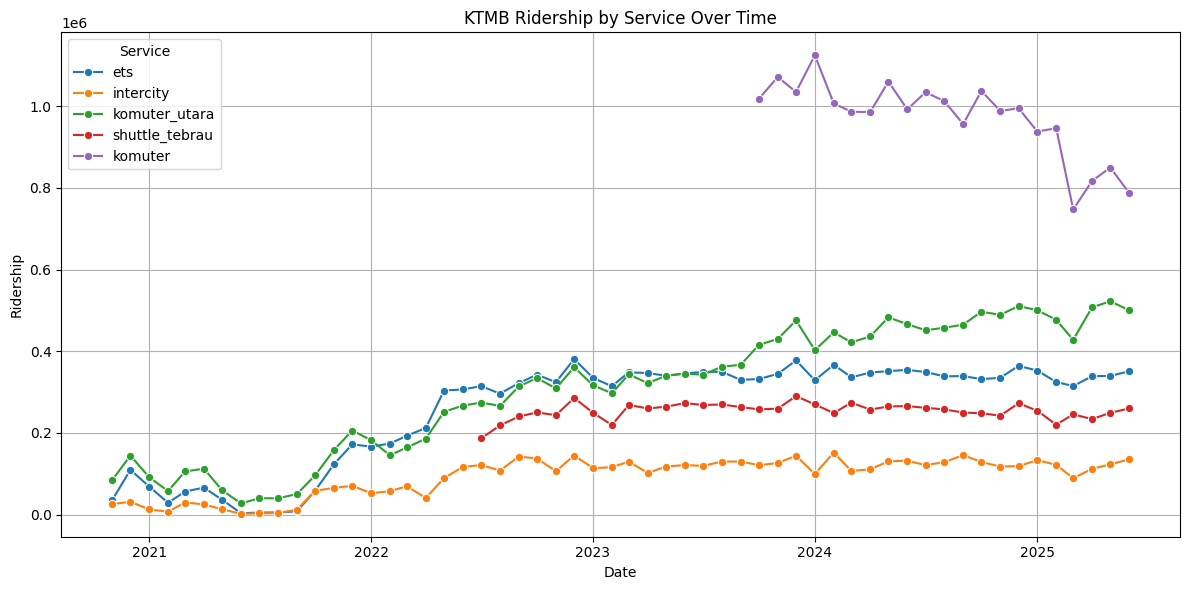

In [15]:
# Plot by service type
plt.figure(figsize=(12, 6))
sns.lineplot(data=ridership_df, x='date', y='ridership', hue='service', marker='o')
plt.title('KTMB Ridership by Service Over Time')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend(title='Service')
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation of the Chart: KTMB Ridership by Service Over Time

- Komuter consistently has the highest ridership since its data appeared in late 2023.
- Services like `ETS` and `Komuter Utara` show steady post-pandemic growth.
- The staggered start dates for services reflect KTMB's phased data rollout, namely `Shuttle Tebrau` in red and `Komuter` in purple.

---

## Plot 3: Active COVID-19 Cases in West Malaysia

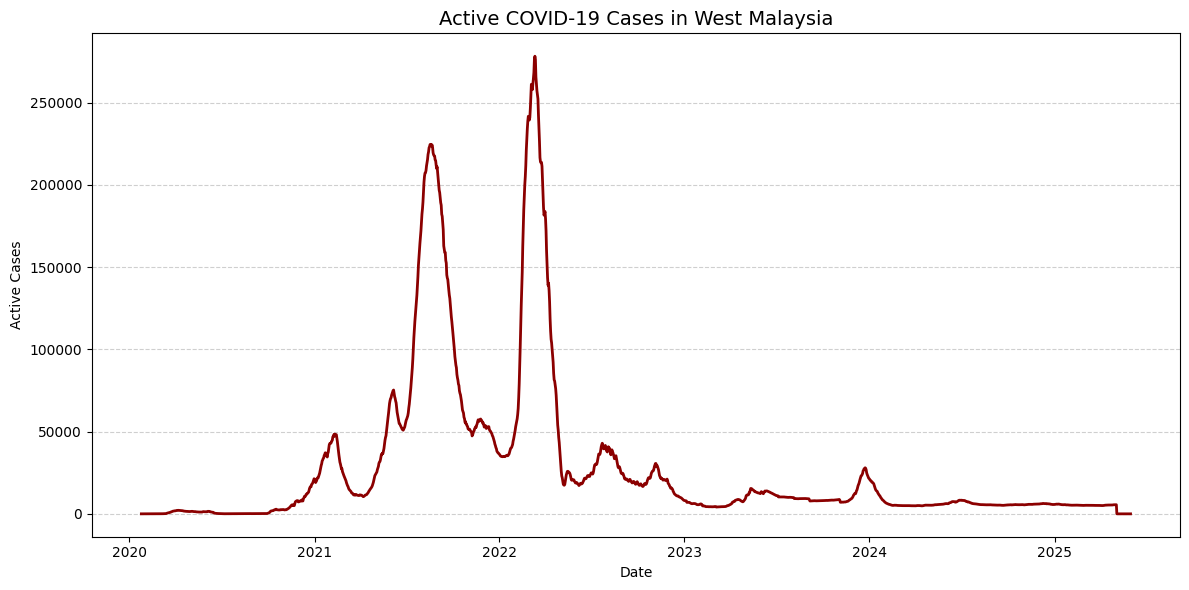

In [16]:
# Create plot
plt.figure(figsize=(12, 6))
plt.plot(west_covid_df['date'], west_covid_df['cases_active'], color='darkred', linewidth=2)

# Titles and labels
plt.title('Active COVID-19 Cases in West Malaysia', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Active Cases')

# Format x-axis: show one tick per year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Horizontal gridlines
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### Interpretation of the Chart: Active COVID-19 Cases in West Malaysia

- **Early 2021:** Marks Malaysia’s third wave, with cases rising after the Sabah elections and leading to MCO 2.0. This was the first prolonged surge in national infections.
- **Mid-2021:** Corresponds with the Delta variant surge and tightening of MCO restrictions.
- **Early 2022:** The largest wave, aligning with the emergence of the Omicron variant.
- **Late 2022–2024:** Smaller fluctuations, suggesting more controlled outbreaks and a transition toward endemic status.

- Sharp declines after each peak suggest effective (though delayed) interventions, possibly due to:
  - Nationwide lockdowns,
  - Public health campaigns,
  - Accelerated vaccination efforts.

---

# 📊 Exploratory Data Analysis (EDA)

Public transport systems, such as KTMB, are high-risk environments for virus transmission due to enclosed spaces and large passenger volumes. As such, ridership data provides a useful proxy for population mobility.

By aligning ridership data with MCO timelines and COVID-19 case trends, we can evaluate the impact of movement restrictions on outbreak dynamics. Reductions in ridership during MCO phases are interpreted as behavioural responses to government mandates, with the expectation that lower mobility should be followed by reductions in active cases.

## Plot 1: Monthly KTMB Ridership with MCO Phases and KITS Rollouts

**📌 Notes on MCO Phases:**

- **RMCO (Recovery Movement Control Order)**: Implemented to gradually reopen the economy and resume social activities while still enforcing SOPs such as physical distancing and mask-wearing. It marked a transition from strict lockdowns to controlled recovery.

- **FMCO (Full Movement Control Order)**: Introduced in response to surging COVID-19 cases, this was effectively a strict nationwide lockdown with most economic and social sectors shut down, similar to the initial MCO in March 2020.

- **NRP (National Recovery Plan)**: A structured, phase-based exit strategy from the pandemic. States moved through 4 phases based on metrics like ICU capacity, case numbers, and vaccination rates. This allowed for gradual reopening tailored to each state's situation.


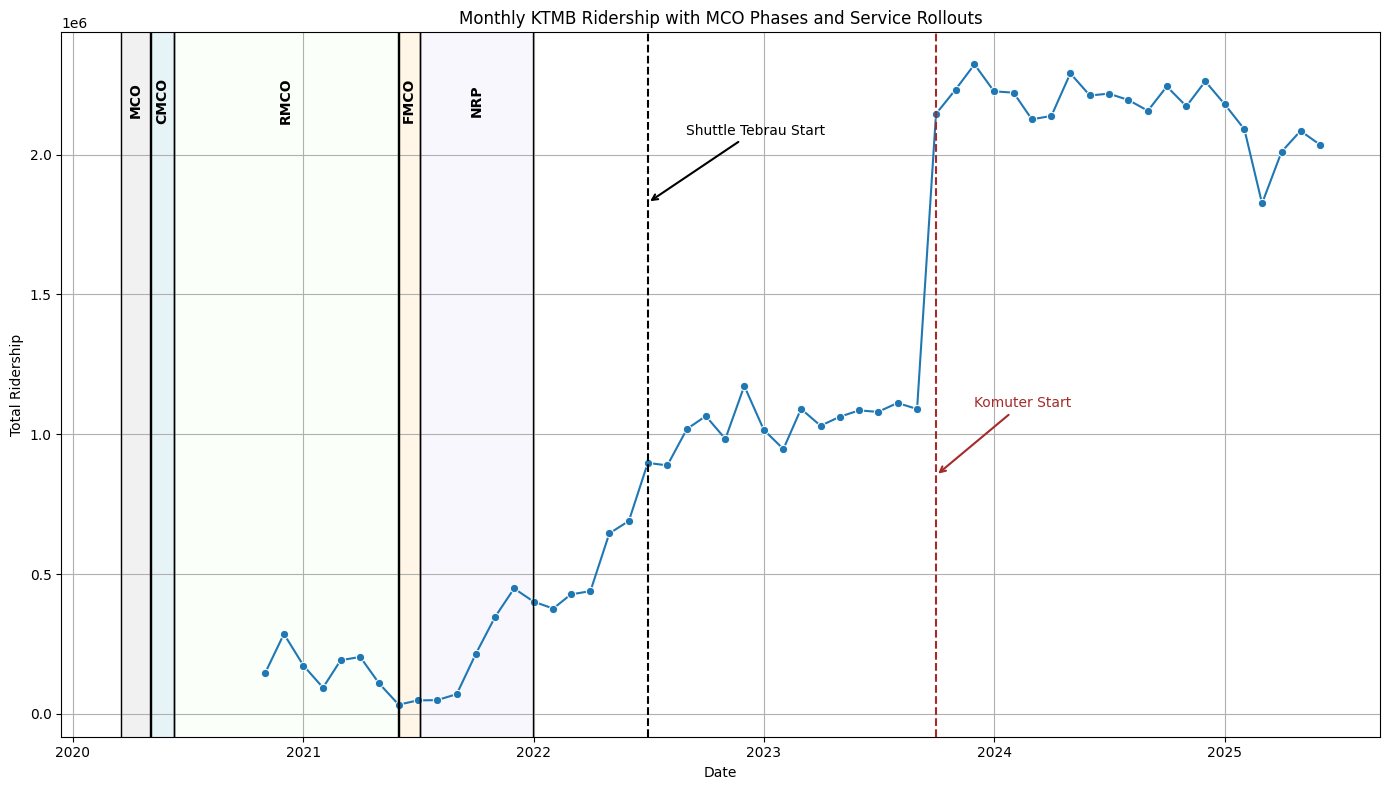

In [17]:
# Define MCO phase colors
colors = {
    'MCO': 'lightgrey',
    'CMCO': 'lightblue',
    'RMCO': 'honeydew',
    'FMCO': 'moccasin',
    'NRP': 'lavender'
}

# Plot setup
plt.figure(figsize=(14, 8))
sns.lineplot(data=monthly_ridership, x='date', y='ridership', marker='o')

# Add MCO shading and centered vertical labels
for _, row in mco_df.iterrows():
    plt.axvspan(row['start_date'], row['end_date'], color=colors[row['phase']], alpha=0.3)
    mid_date = row['start_date'] + (row['end_date'] - row['start_date']) / 2
    plt.text(mid_date, plt.ylim()[1] * 0.9, row['phase'], ha='center', va='center',
             rotation=90, fontsize=10, fontweight='bold')

# Add boundary lines for each phase
for _, row in mco_df.iterrows():
    plt.axvline(row['start_date'], color='black', lw=1)
    plt.axvline(row['end_date'], color='black', lw=1)

# KITS rollout markers (as vertical lines)
tebrau_date = pd.to_datetime('2022-07-01')
komuter_date = pd.to_datetime('2023-10-01')

plt.axvline(tebrau_date, color='black', linestyle='--')
plt.axvline(komuter_date, color='brown', linestyle='--')

# Annotate rollout lines instead of using legend
plt.annotate('Shuttle Tebrau Start',
             xy=(tebrau_date, plt.ylim()[1] * 0.75),
             xytext=(tebrau_date + pd.Timedelta(days=60), plt.ylim()[1] * 0.85),
             arrowprops=dict(arrowstyle='->', lw=1.5, color='black'),
             fontsize=10, color='black')

plt.annotate('Komuter Start',
             xy=(komuter_date, plt.ylim()[1] * 0.35),
             xytext=(komuter_date + pd.Timedelta(days=60), plt.ylim()[1] * 0.45),
             arrowprops=dict(arrowstyle='->', lw=1.5, color='brown'),
             fontsize=10, color='brown')

# Title and labels
plt.title('Monthly KTMB Ridership with MCO Phases and Service Rollouts')
plt.xlabel('Date')
plt.ylabel('Total Ridership')
plt.grid(True)
plt.tight_layout()
plt.show()

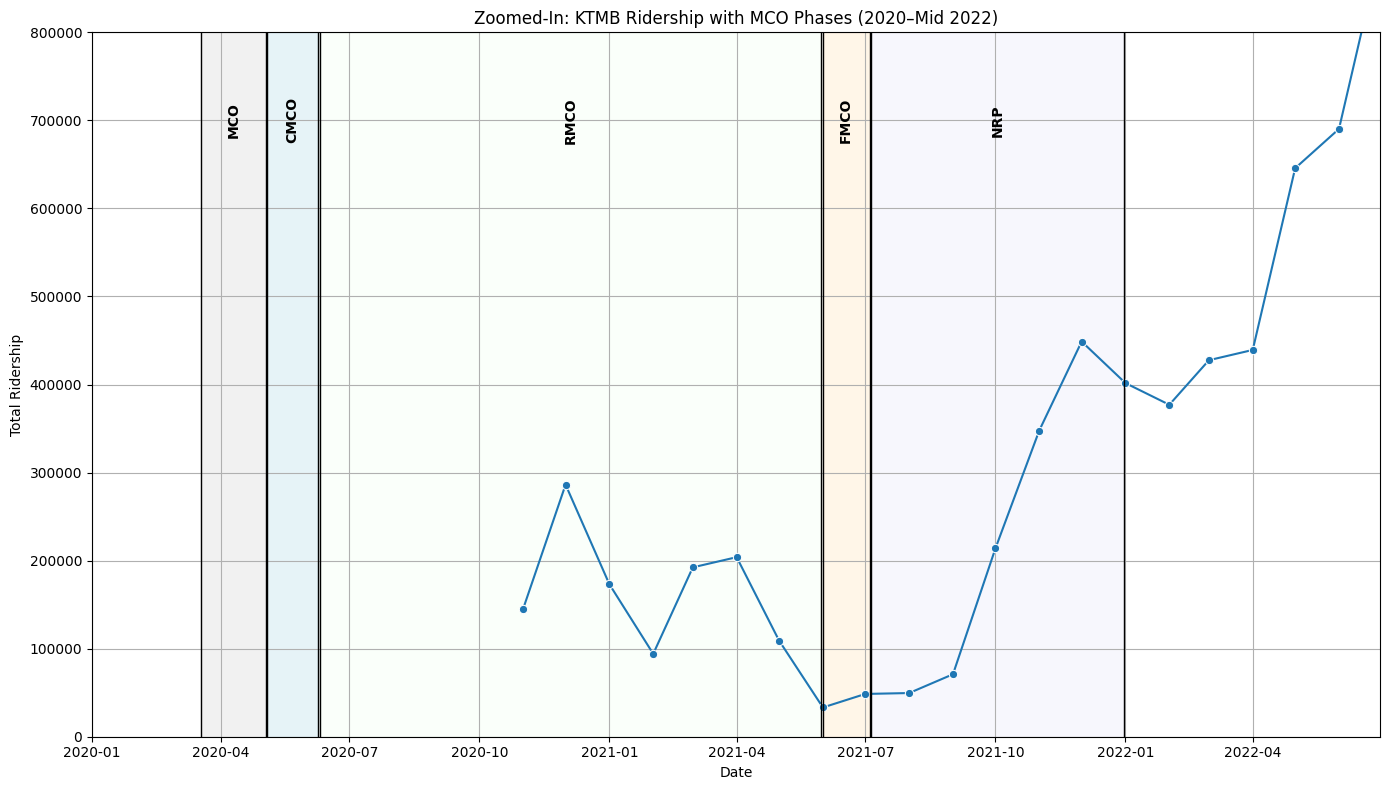

In [18]:
# Define MCO phase colors
colors = {
    'MCO': 'lightgrey',
    'CMCO': 'lightblue',
    'RMCO': 'honeydew',
    'FMCO': 'moccasin',
    'NRP': 'lavender'
}

# Plot setup
plt.figure(figsize=(14, 8))  # Increased height to accommodate text
sns.lineplot(data=monthly_ridership, x='date', y='ridership', marker='o')

# Add MCO shading and centered vertical labels
for _, row in mco_df.iterrows():
    plt.axvspan(row['start_date'], row['end_date'], color=colors[row['phase']], alpha=0.3)
    mid_date = row['start_date'] + (row['end_date'] - row['start_date']) / 2
    plt.text(mid_date, 700_000, row['phase'], ha='center', va='center', rotation=90, fontsize=10, fontweight='bold')

# Add boundary lines for each phase
for _, row in mco_df.iterrows():
    plt.axvline(row['start_date'], color='black', lw=1)
    plt.axvline(row['end_date'], color='black', lw=1)

# Title and labels
plt.title('Zoomed-In: KTMB Ridership with MCO Phases (2020–Mid 2022)')
plt.xlabel('Date')
plt.ylabel('Total Ridership')
plt.grid(True)

# Set zoomed-in view
plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2022-06-30'))
plt.ylim(0, 800_000)

plt.tight_layout()
plt.show()

### Interpretation of the Chart: KTMB Ridership with MCO Phases and KITS Rollouts

#### Observations

- Data begins in October 2020 during RMCO, capturing early recovery after Malaysia’s first MCO (not shown in the dataset).
- Fluctuations in 2021 reflect key pandemic events:
  - **Early 2021:** A slight dip aligns with pandemic resurgence and renewed movement controls.
  - **Mid-2021 (Delta variant):** Ridership falls sharply during FMCO, a strict lockdown in response to the Delta wave.
  - **Late 2021 (NRP period):** Ridership begins to recover, aided by easing restrictions and the emergence of the Omicron variant, which led to high case counts but fewer lockdowns.
- **2022 to 2023:** Ridership steadily increases and stabilises, indicating public adaptation and improved government response under endemic management.
- **Post-NRP (Endemic Phase):**
  - `Shuttle Tebrau` (2022) and `Komuter` (late 2023) rollouts coincide with distinct spikes, reflecting newly included service data rather than a surge in demand.
  - Excluding these rollouts, ridership remains steady and elevated, pointing to normalised travel and a return to regular public transport usage.

#### Insights

- Ridership trends closely mirror COVID-19 policy changes and major variant impacts.
- The steady rebound from 2022 onwards reflects effective endemic management and growing public confidence in KTMB services.

#### Next Steps

- Compare ridership trends directly against active COVID-19 cases to validate visual correlations.
- Consider incorporating vaccination milestones and border reopening dates to contextualise ridership recovery.


---

## Plot 2: Total KTMB Ridership vs Active COVID-19 Cases

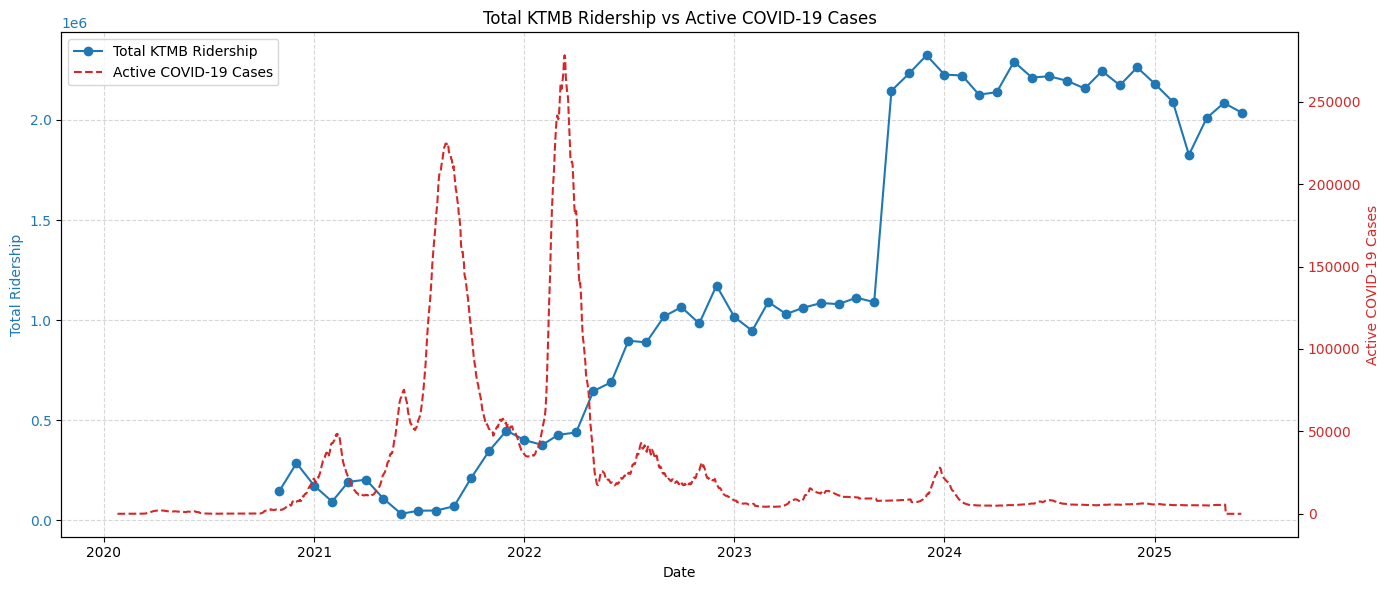

In [19]:
# Plot setup
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot monthly ridership
ax1.plot(monthly_ridership['date'], monthly_ridership['ridership'], color='tab:blue', marker='o', label='Total KTMB Ridership')
ax1.set_ylabel('Total Ridership', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xlabel('Date')

# Format x-axis to show only years
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=0, ha='center')

# Add second y-axis for active cases
ax2 = ax1.twinx()
ax2.plot(west_covid_df['date'], west_covid_df['cases_active'], color='tab:red', linestyle='--', label='Active COVID-19 Cases')
ax2.set_ylabel('Active COVID-19 Cases', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and grid
plt.title('Total KTMB Ridership vs Active COVID-19 Cases')
ax1.grid(True, which='major', linestyle='--', alpha=0.5)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

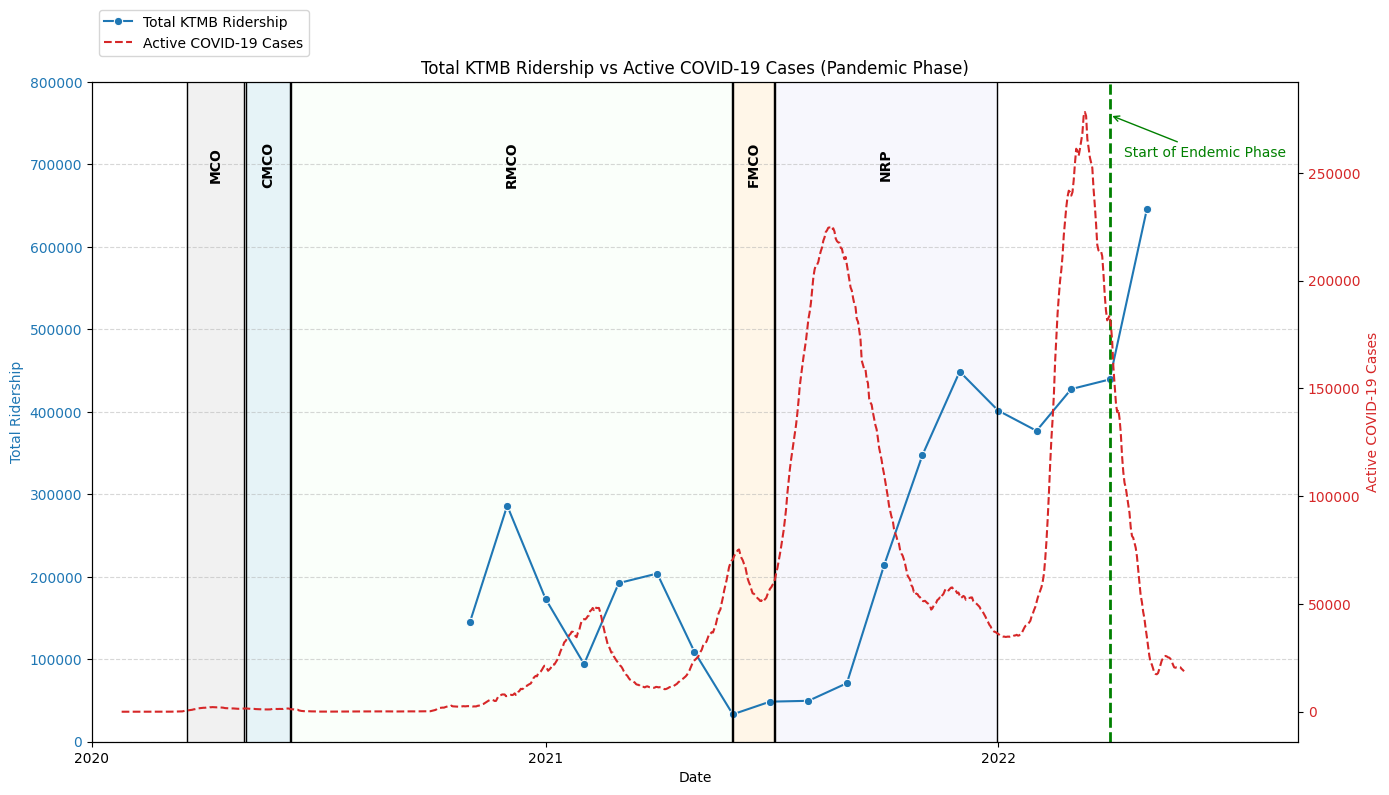

In [20]:
# Filter pre-endemic data (before April 1, 2022), but we include Omicron for additional context
cutoff = pd.to_datetime("2022-06-01") # To show Omicron introduction and response
ridership_cut = monthly_ridership[monthly_ridership["date"] < cutoff]
cases_cut = west_covid_df[west_covid_df["date"] < cutoff]

# Define colors for MCO phases
colors = {
    'MCO': 'lightgrey',
    'CMCO': 'lightblue',
    'RMCO': 'honeydew',
    'FMCO': 'moccasin',
    'NRP': 'lavender'
}

# Plot setup
fig, ax1 = plt.subplots(figsize=(14, 8))

# Primary y-axis: KTMB ridership
sns.lineplot(data=ridership_cut, x='date', y='ridership', marker='o', ax=ax1, label="Total KTMB Ridership", color="tab:blue")
ax1.set_ylabel("Total Ridership", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True, axis="y", linestyle="--", alpha=0.5)

# Add MCO shading and vertical labels
for _, row in mco_df.iterrows():
    ax1.axvspan(row['start_date'], row['end_date'], color=colors[row['phase']], alpha=0.3)
    mid_date = row['start_date'] + (row['end_date'] - row['start_date']) / 2
    ax1.text(mid_date, 700_000, row['phase'], ha='center', va='center', rotation=90,
             fontsize=10, fontweight='bold')

# Add boundary lines for MCO phases
for _, row in mco_df.iterrows():
    ax1.axvline(row['start_date'], color='black', lw=1)
    ax1.axvline(row['end_date'], color='black', lw=1)

# Raise ylim to accommodate text
ax1.set_ylim(0, 800_000)

# Secondary y-axis: Active COVID-19 cases
ax2 = ax1.twinx()
ax2.plot(cases_cut["date"], cases_cut["cases_active"], color="tab:red", linestyle="--", label="Active COVID-19 Cases")
ax2.set_ylabel("Active COVID-19 Cases", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Format x-axis (year only)
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.set_xlabel("Date")

# Titles and legend
ax1.set_title("Total KTMB Ridership vs Active COVID-19 Cases (Pandemic Phase)")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0,1.12))

# Annotate endemic phase start (April 1, 2022)
endemic_start = pd.to_datetime("2022-04-01")
ax1.axvline(endemic_start, color='green', linestyle='--', linewidth=2)
ax1.annotate(
    "Start of Endemic Phase",
    xy=(endemic_start, ax1.get_ylim()[1]*0.95),
    xytext=(10, -30),
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->', color='green'),
    color='green',
    fontsize=10,
    ha='left'
)

# Extend x-axis for annotation padding
new_xlim = pd.to_datetime(['2020-01-01', '2022-08-31'])
ax1.set_xlim(new_xlim)

# Final layout
plt.tight_layout()
plt.show()

### Interpretation: Total KTMB Ridership vs Active COVID-19 Cases

This dual-axis chart demonstrates a clear relationship between mobility restrictions and outbreak control.

- Each major MCO phase was accompanied by a sharp drop in KTMB ridership. These declines often preceded reductions in active COVID-19 cases, suggesting that movement restrictions were effective in limiting community spread.
- The most notable case is the FMCO in mid-2021, where ridership fell steeply and was followed by a sustained decline in cases during the Delta wave.
- During the Omicron wave in early 2022, ridership dropped only slightly and recovered quickly, even though cases surged to record levels. This marks a turning point in the strategy, as Malaysia began transitioning to endemic management.
- The eventual decoupling of ridership and case trends from mid-2022 onwards suggests growing public adaptation and a policy shift away from mobility suppression.

The visual evidence supports the view that MCOs, particularly when strictly implemented, were effective tools for reducing virus transmission through population movement control.


# 📝 Conclusion

This project evaluated whether Malaysia’s COVID-19 movement restrictions, primarily through MCO phases, were effective in reducing virus transmission. Using KTMB ridership as a proxy for public mobility, we found a consistent pattern: strict movement restrictions were followed by drops in ridership, which were then followed by reductions in active case counts.

The clearest example is during the Delta wave and FMCO, where ridership fell dramatically and active cases declined soon after. This suggests that MCOs functioned as intended by breaking chains of transmission through limited movement.

By contrast, the Omicron period and endemic phase reveal a shift in strategy. Ridership rebounded despite high case numbers, indicating reduced reliance on mobility control and greater dependence on vaccination and adaptation.

### Key Takeaways

- MCOs were largely effective at reducing cases during the early to mid-pandemic period.
- KTMB ridership served as a meaningful proxy for mobility and behavioural change.
- Over time, the link between mobility and case trends weakened, reflecting a policy shift towards coexistence.

### Future Directions

- Incorporate time-lagged correlation to model the delay between ridership drops and case declines.
- Add vaccination and hospitalisation data for a more comprehensive view.
- Compare with other mobility datasets (e.g. Google Mobility Reports) to validate findings.